<a href="https://colab.research.google.com/github/Santlaj/ML_prediction_model/blob/main/Stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/yahoo.csv')


In [ ]:

df = pd.read_csv('yahoo.csv', quotechar='"', thousands=',', engine='python', skip_blank_lines=True)


In [ ]:

df = df.astype(str)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

df['Close'] = df['Close*'].astype(str).str.replace(',', '').astype(float)

df = df[['Date', 'Close']].sort_values('Date').reset_index(drop=True)
print(df.head())


        Date     Close
0 2018-05-01  24099.05
1 2018-05-02  23924.98
2 2018-05-03  23930.15
3 2018-05-04  24262.51
4 2018-05-07  24357.32


In [ ]:
for col, window in zip(['ma_3', 'ma_7'], [3, 7]):
    df[col] = df['Close'].rolling(window=window).mean()
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df = df.dropna().reset_index(drop=True)

features = ['lag_1', 'lag_2', 'ma_3', 'ma_7']


In [ ]:
split_idx = int(len(df) * 0.8)
train_df, valid_df = df.iloc[:split_idx], df.iloc[split_idx:]

In [ ]:
model = LinearRegression()
model.fit(train_df[features], train_df['Close'])

LinearRegression()

In [ ]:
def predict_and_eval(df_part, label):
    preds = model.predict(df_part[features])
    mse = mean_squared_error(df_part['Close'], preds)
    rmse = np.sqrt(mse)
    print(f"{label} MSE: {mse:.2f} RMSE: {rmse:.2f}")
    return preds

train_preds = predict_and_eval(train_df, "Train")
valid_preds = predict_and_eval(valid_df, "Validation")

Train MSE: 0.00 RMSE: 0.00
Validation MSE: 0.00 RMSE: 0.00


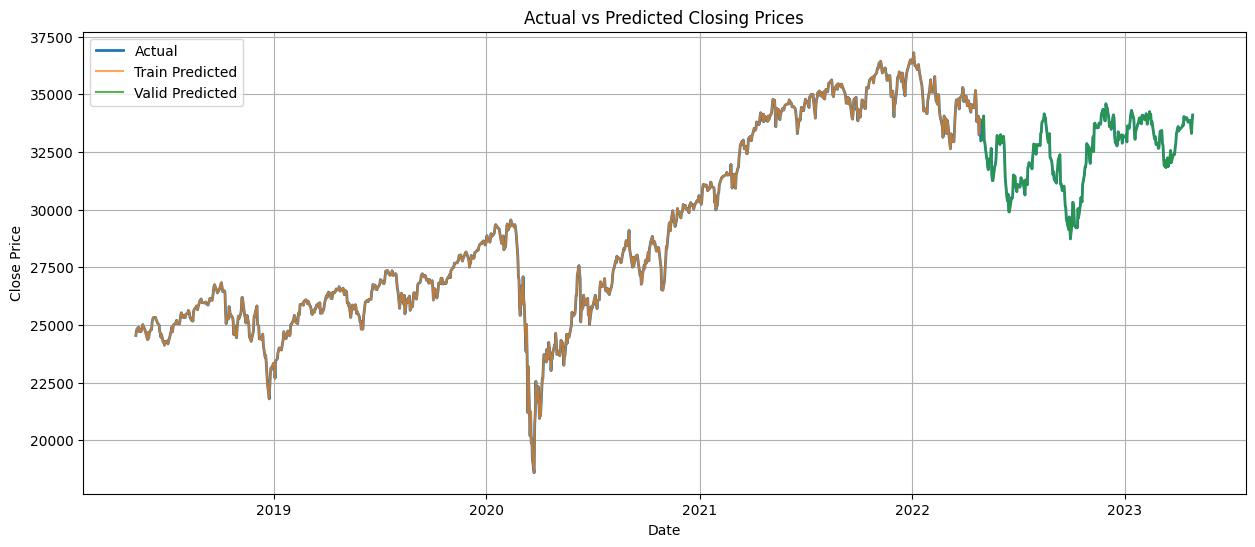

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close'], label='Actual', lw=2)
plt.plot(train_df['Date'], train_preds, label='Train Predicted', alpha=0.7)
plt.plot(valid_df['Date'], valid_preds, label='Valid Predicted', alpha=0.8)
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
future_rows = []
last_known = df.iloc[-1:].copy()
feature_cols = ['lag_1', 'lag_2', 'ma_3', 'ma_7']

for i in range(7):
    latest = last_known.iloc[-1]
    lag_1 = latest['Close']
    lag_2 = latest['lag_1']

    # Calculating moving averages for the forecasted point.
    prev_closes = [lag_1, lag_2, latest['lag_2']]
    ma_3 = np.mean([float(x) for x in prev_closes])
    prev_ma7 = [lag_1, lag_2, latest['lag_2'], latest['ma_3'], latest['ma_7'], lag_1, lag_2]
    ma_7 = np.mean([float(x) for x in prev_ma7])
    # Prepare DataFrame for prediction to avoid warning.
    X_new = pd.DataFrame([[lag_1, lag_2, ma_3, ma_7]], columns=feature_cols)
    predicted_close = model.predict(X_new)[0]
    pred_date = latest['Date'] + pd.Timedelta(days=1)
    future_rows.append({'Date': pred_date, 'Close': predicted_close})
    # Adding the new prediction as a pseudo-row to last_known for the next roll.
    last_known = pd.concat([
        last_known,
        pd.DataFrame([{
            'Date': pred_date,
            'Close': predicted_close,
            'lag_1': lag_1,
            'lag_2': lag_2,
            'ma_3': ma_3,
            'ma_7': ma_7
        }])
    ], ignore_index=True)
future_df = pd.DataFrame(future_rows)
print("\n7-day Price Forecast:")
print(future_df[['Date', 'Close']].to_string(index=False))


7-day Price Forecast:
      Date    Close
2023-04-29 33301.87
2023-04-30 33826.16
2023-05-01 34098.16
2023-05-02 33301.87
2023-05-03 33826.16
2023-05-04 34098.16
2023-05-05 33301.87
